# Imports

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 ghostscript libapache-pom-java libcommons-logging-java
  libcommons-parent-java libfontbox-java libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35
  libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0 libsynctex2 libteckit0
  libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern pfb2t1c2pfb poppler-data
  preview-latex-style rake ruby ruby-net-telnet ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0
  rubygems-integration t1utils tex-common tex-gyre texlive-base texlive-binaries
  texlive-fonts-recommended texlive-latex-base texlive-pictures texlive-plain-generic tipa
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf ghostscript-x libavalon-framework-

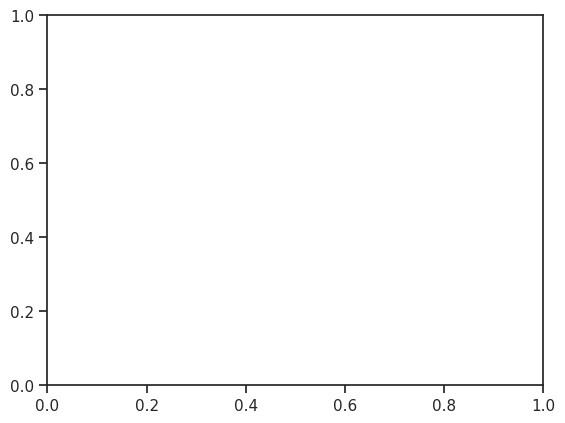

In [1]:
!apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
!pip install numpyro
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
sns.set_theme(style="ticks")

plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['ytick.labelsize'] = 22
plt.rc('axes', labelsize=22)
plt.rc('legend', fontsize=22)
mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

%matplotlib inline
from typing import Callable
import matplotlib.pyplot as plt
from jax import numpy as jnp
from jax import scipy
from jax import random, Array, jit, vmap, grad
from jax.tree_util import Partial as partial
from jax.lax import fori_loop, cond, dynamic_slice
import numpyro
import optax
import jax
#from jax.config import config

#config.update("jax_debug_nans", True)
jax.config.update("jax_enable_x64", True)
#optax.clip_by_global_norm(1)
import pickle
import sklearn

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import pickle

Mounted at /content/drive


In [3]:
key = random.PRNGKey(0)

# Import data, split train and test

In [4]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler

X, y = fetch_openml(data_id=181, as_frame=True, return_X_y=True)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X_train = X[:1300, :]
y_train = y[:1300]
X_test = X[1300:, :]
y_test = y[1300:].reset_index()
y.value_counts().sort_index()

,count
class_protein_localization,
CYT,463
ERL,5
EXC,35
ME1,44
ME2,51
ME3,163
MIT,244
NUC,429
POX,20


In [5]:
cats = {"CYT" : 0, "ERL": 1, "EXC": 2, "ME1": 3, "ME2": 4, "ME3": 5, "MIT": 6, "NUC": 7, "POX": 8, "VAC": 9}
cats_reversed = {0: "CYT", 1: "ERL", 2:"EXC", 3:"ME1", 4:"ME2", 5:"ME3", 6:"MIT", 7:"NUC", 8:"POX", 9:"VAC"}

# Target measure, kernel and test functions

In [6]:
def norm_2_safe_for_grad(x) :

      return jnp.power(jnp.linalg.norm(jnp.where(x != 0., x, 0.)), 2)

def K(x, y):#gaussian kernel

      return jnp.exp(-0.5* norm_2_safe_for_grad(x-y))

In [7]:
#\beta_0, \beta_1, \beta_2, \beta_3 \sim iid from N(0, 10) truncated at 100 for each class
#prior on parameters
sigma = 10.

class gaussian_trunc(numpyro.distributions.Distribution) :

    def __init__(self):

        self.d = 1
        self.sigma = sigma
        event_shape = (1, )
        super(gaussian_trunc, self).__init__(event_shape = event_shape)

    def outlier(self, value):

        return jnp.linalg.norm(value) >= 5*self.sigma

    def log_prob(self, value) :

        out = self.outlier(value)
        res = cond(out,
                   lambda _ : -jnp.inf,
                   lambda _ : -jnp.linalg.norm(value)**2/(2*self.sigma**2),
                   None)

        return res

class gaussian_trunc_mult(numpyro.distributions.Distribution) :

    def __init__(self):

        event_shape = (9*9, ) #intercept + 8 features, 10 class but the prob for the last one is 1 minus the others
        super(gaussian_trunc_mult, self).__init__(event_shape = event_shape)

    def log_prob(self, value):

        return jit(vmap(gaussian_trunc().log_prob))(value)

In [8]:
key, _ = random.split(key, 2)
target = gaussian_trunc_mult()
mvn = numpyro.distributions.MultivariateNormal(loc=jnp.zeros(81), covariance_matrix= jnp.eye(81))
mvn_samples = mvn.sample(key, (1, ))
target.log_prob(mvn_samples)

Array([-0.42636313], dtype=float64)

In [9]:
#incorporate likelihood from the data

def log_sigmoid(value_k, x):

    return jnp.dot(value_k, jnp.concatenate([jnp.array([1.]), x]))

def log_sigmoid_normalized(x, y, value_reshaped, K_max):
    cat = y
    log_sigmoids = jit(vmap(partial(log_sigmoid, x = x)))
    sigmoids = log_sigmoids(value_reshaped[:(K_max -1), :])
    sm = scipy.special.logsumexp(jnp.concatenate([sigmoids, jnp.array([1.])]))

    return jnp.where(cat == K_max, -sm, log_sigmoids(value_reshaped[cat, :])[0]- sm)

class logit_prior(numpyro.distributions.Distribution):

    def __init__(self):

        self.K_max = 9
        event_shape = (9*9, ) #intercept + 8 features, 10 class but the prob for the last one is 1 minus the others
        super(logit_prior, self).__init__(event_shape = event_shape)

    def log_prob(self, value):

        n_features = X_train[0, :].shape[0]
        value_reshaped = value.reshape((n_features+1, self.K_max)).T
        cat_train = jnp.array([cats[y] for y in y_train], dtype = int)
        n_train = y_train.shape[0]
        s = jit(vmap(partial(log_sigmoid_normalized, value_reshaped = value_reshaped, K_max = self.K_max)))(X_train, cat_train).sum()

        return gaussian_trunc_mult().log_prob(value) + s


In [10]:
key, _ = random.split(key, 2)
target = logit_prior()
mvn = numpyro.distributions.MultivariateNormal(loc=jnp.zeros(81), covariance_matrix= jnp.eye(81))
mvn_samples = mvn.sample(key, (1, ))
target.log_prob(mvn_samples)

Array([-55085.62709034], dtype=float64)

In [11]:
#likelihood for bayesian logistic regression using test data
n_features = X_train[0, :].shape[0]
K_max = target.K_max

def log_likelihood(value_reshaped, x, y):

    log_lik_x = log_sigmoid_normalized(x = x, y = y, value_reshaped= value_reshaped, K_max = K_max)

    return log_lik_x

#compute posterior probability to predict each class with given samples from the prior and data
def log_posterior(samples, x, cat = "CYT"):

    n, d_sample = samples.shape
    y = cats[cat]
    samples_reshaped = samples.reshape(n, K_max, n_features +1)
    f_log_post = lambda value : log_likelihood(value_reshaped = value, x=x, y = y)
    log_post = scipy.special.logsumexp(jit(vmap(f_log_post))(samples_reshaped))  #pb ici ? il veut fiare les chsoes en vectorisé ? le format est pas bon
    return log_post - jnp.log(n)

def classify(samples, x):

    log_posts = np.array([log_posterior(samples, x = x, cat = cat) for cat in cats.keys()])
    khat =  cats_reversed[np.argmax(log_posts)]
    return khat


In [12]:
key, _ = random.split(key, 2)
samples = mvn.sample(key, (10, ))
classify(samples, x = X_test[50, :])

'ERL'

In [13]:
y_test.iloc[50]

,50
index,1350
class_protein_localization,CYT


# Gibbs target and MALA

In [14]:
class gibbs(numpyro.distributions.Distribution) :

    def __init__(self, d, N, K, V, beta_N) :

        self.N = N
        self.K = K
        self.V = V
        self.d = d
        self.beta_N = beta_N
        event_shape = (N, d)
        super(gibbs, self).__init__(event_shape = event_shape)


    def log_prob(self, value) :

        #value = (x_1, \dots, x_N)

        value_shape = value.shape #should be (1, N*d)
        X = jnp.array(value.reshape(self.d, self.N))
        index = jnp.array([k for k in range(self.N)])

        k_inter = lambda j ,k : self.K(X[:, j], X[:, k])

        pair_j = lambda j : jit(vmap(partial(k_inter, j)))(index).sum()
        diag = jit(vmap(k_inter))(index, index).sum()
        #diag = 0
        pair_jit = jit(vmap(pair_j))(index).sum()
        #pair_jit = jnp.array([[k_inter(j, k) for k in index] for j in index]).sum()
        #pair_inter = jnp.log(self.beta_N) +jnp.log(pair_jit - diag ) -jnp.log(2) - 2*jnp.log(self.N)
        pair_inter = self.beta_N * (pair_jit - diag) / (2 * self.N**2)

        v_inter = lambda j : self.V(X[:, j])
        ext_jit = jit(vmap(v_inter))(index).sum()
        #ext_jit = jnp.array([v_inter(j) for j in index]).sum()
        #exter_V =  jnp.log(self.beta_N) +jnp.log(ext_jit) - jnp.log(self.N)
        exter_V = self.beta_N * ext_jit / self.N

        return - pair_inter - exter_V
        #return  -jnp.exp(exter_V)*(jnp.exp(pair_inter - exter_V) +1)

In [15]:
def mala(key: Array,
         start_sample: Array,
         log_prob_target: Callable[[jnp.ndarray], jnp.ndarray],
         n_iter: int,
         step_size: float) -> jnp.ndarray:
    '''
    This function implements MALA sampler.
    :param key: PRNGArray specifying the key that is used for the random numbers
    :param start_sample: Array with the first element
    :param log_prob_target: Function that calculates the log probability of the target distribution at a given point.
    :param n_iter: int The number of steps of the chain.
    :param step_size: The step size (gamma above) for the Langevin kernel.
    :return: The last sample of the chain
    '''
    val = (start_sample, key, 0.)
    #you need to define the gradient of the log_prob_target parameter
    grad_logpdf = grad(lambda x: log_prob_target(x))

    def mh_step(i, val):

        sample, key, acceptance = val
        key, subkey_u, subkey_sample = random.split(key, 3)
        #Sample the langevin kernel

        noise = random.normal(subkey_sample, (sample.shape[-1],))
        next = sample + step_size * grad_logpdf(sample) \
               + jnp.sqrt(2 * step_size) * noise
        #Compute the log acceptance ratio
        fwd_ker_logprob = - (noise ** 2).sum() / 2
        bwd_ker_logprob = - ((sample - next - step_size * grad_logpdf(next))**2).sum() / (4 * step_size)
        log_ratio = log_prob_target(next) + bwd_ker_logprob - log_prob_target(sample) - fwd_ker_logprob



        log_u = jnp.log(random.uniform(subkey_u))
        accept = log_ratio > log_u
        acceptance = (i*acceptance + accept)/(i+1)

        x = cond(accept,
                 lambda _: next,
                 lambda _: sample,
                 None)
        return (x, key, acceptance)

    sample, k, acceptance = fori_loop(0,
                          n_iter,
                          body_fun=mh_step,
                          init_val=val)
    return sample, acceptance

# Target measure and MCMC to approximate the potential

In [16]:
def mh(key: Array,
         start_sample: Array,
         log_prob_target: Callable[[jnp.ndarray], jnp.ndarray],
         n_iter: int,
         step_size: float) -> jnp.ndarray:
    '''
    This function implements MALA sampler.
    :param key: PRNGArray specifying the key that is used for the random numbers
    :param start_sample: Array with the first element
    :param log_prob_target: Function that calculates the log probability of the target distribution at a given point.
    :param n_iter: int The number of steps of the chain.
    :param step_size: The step size (gamma above) for the Langevin kernel.
    :return: The last sample of the chain
    '''
    val = (start_sample, key, 0.)
    start_sample = jnp.atleast_2d(start_sample)

    def mh_step(i, val):

        positions, key, acceptance = val
        sample = jnp.atleast_2d(positions[i-1, :])
        key, subkey_u, subkey_sample = random.split(key, 3)
        #Sample the langevin kernel
        noise = random.normal(subkey_sample, (sample.shape[-1],))
        next = sample + jnp.sqrt(2 * step_size) * noise
        #Compute the log acceptance ratio
        fwd_ker_logprob = - (noise ** 2).sum() / 2
        bwd_ker_logprob = - ((sample - next)**2).sum() / (4 * step_size)
        log_ratio = log_prob_target(next) + bwd_ker_logprob - log_prob_target(sample) - fwd_ker_logprob

        log_u = jnp.log(random.uniform(subkey_u))
        accept = log_ratio > log_u
        #x = cond(accept,
        #         lambda _: next,
        #         lambda _: sample,
        #         None)
        x = jnp.where(log_ratio > log_u, next, sample)

        acceptance = (i*acceptance + accept)/(i+1)
        positions = positions.at[i, :].set(jnp.atleast_2d(x)[0, :])
        return (positions, key, acceptance)

    all_positions = jnp.zeros((n_iter, start_sample.shape[1]))
    all_positions.at[0, :].set(start_sample[0, :])

    positions, key, acceptance = fori_loop(1,
                          n_iter,
                          body_fun=mh_step,
                          init_val=(all_positions, key, jnp.array([0.])))
    return positions, acceptance

In [38]:
key, _ = random.split(key, 2)
target = logit_prior()
sample_mh_jit = vmap(partial(mh,
                                log_prob_target = target.log_prob,
                                n_iter = 1_000,
                                step_size = 5e-4))
initial_positions = mvn.sample(key, (1, ))
sample_mh_pot_jit, acceptance = jit(sample_mh_jit)(random.split(key, 1), initial_positions)
sample_mh_pot = sample_mh_pot_jit[0, :, :].T

In [39]:
acceptance

Array([[0.332]], dtype=float64)

In [40]:
def V_ext(x):

    R_2 = 9*9*(5* sigma)**2
    outlier = norm_2_safe_for_grad(x) >= R_2
    res = jnp.where(outlier, norm_2_safe_for_grad(x) - R_2, 0.)
    return res

def V(x) :

    d, N_mh = sample_mh_pot.shape
    #attention dans le papier simods j'ai pris le même échantillon mcmc pour tous les x, c'est ok car on a les garanties en W_1 mais est ce qu'on a pas intérêt à indep ?
    k_inter = lambda j : K(x, sample_mh_pot[:, j])
    v_inter = jit(vmap(k_inter))(jnp.array([k for k in range(N_mh)])).sum() / N_mh

    return V_ext(x) - v_inter

# Compute probability estimates with long MCMC chains and classify

In [ ]:
#ça devrait aller mh marche déjà

# Compute estimates and simultaneous confidence intervals with Gibbs and classify

## One chain and classify

In [ ]:
key, _ = random.split(key, 2)
d = 81
N = 100
beta_N = 2*N**2
target_mala = gibbs(d = d, N = N, K = K, V = V, beta_N = beta_N)
mvn_d = numpyro.distributions.MultivariateNormal(loc=jnp.zeros(d*N), covariance_matrix= jnp.eye(d*N))
start_sample = mvn_d.sample(key, (1, ))

In [ ]:
sample_mala, acceptance = jit(vmap(partial(mala,
                               log_prob_target = target_mala.log_prob,
                               n_iter = 10_000,
                               step_size =  0.01 * beta_N**(-1))))(random.split(key, 1), start_sample)
sample_mala_reshaped = sample_mala.reshape(d, N).T
#sample_mala_reshaped = sample_mala.reshape((n_chains, d, N)).T
#classify(sample_mala_reshaped, x = X_test[0, :])

In [ ]:
sample_mala_reshaped

Array([[-0.21022036,  0.37365164, -0.86603561, ...,  1.74583989,
         0.68863076,  0.43664929],
       [-0.40866136, -3.04816463, -1.55106687, ..., -0.22393197,
        -1.74872247,  0.79185282],
       [-0.70987667,  0.12203354,  2.38018893, ...,  0.03765181,
         0.97003735,  0.67406929],
       ...,
       [ 0.63098112, -0.49025407, -0.82912314, ...,  0.94809742,
        -1.27525514, -0.06205483],
       [ 0.28271069, -0.53505393,  0.62540374, ...,  0.67770592,
         1.21857353,  1.06645349],
       [ 1.18697898,  0.3300827 ,  0.81312536, ...,  1.11951992,
         1.207932  , -1.42598009]], dtype=float64)

In [ ]:
y_test.iloc[0]

,0
index,1300
class_protein_localization,CYT


## 50 chains to compute confidence intervals

In [ ]:
n_chains = 50
N = 500
d = 81
beta_N = 2*N**2
n_iter = 10_000
step_size = 8*1e4
target_mala = gibbs(d = d, N = N, K = K, V = V, beta_N = beta_N)
mvn_d = numpyro.distributions.MultivariateNormal(loc=jnp.zeros(d), covariance_matrix= jnp.eye(d))
all_acceptance = jnp.array([0. for k in range(n_chains)])
all_chains = jnp.zeros(shape = (n_chains, N, d))
dict_chain_gibbs_500 = {"N" : N,
                        "temp" : "2*N**2",
                        "n_chains" : n_chains,
                        "step_size" : step_size,
                        "n_iter" : n_iter,
                        "n_iter_pot" : 1_000,
                        "step_size_pot" : 5e-4,
                        "acceptance" : all_acceptance,
                        "chains" : all_chains}
#pickle.dump(dict_chain_gibbs_500, open("drive/MyDrive/results_gretsi/mala_chains/chain_gibbs_500.p", "wb"))

In [ ]:
dict_chain_gibbs_500 = pickle.load(open("drive/MyDrive/results_gretsi/mala_chains/chain_gibbs_500.p", "rb"))
all_acceptance = dict_chain_gibbs_500["acceptance"]
all_chains = dict_chain_gibbs_500["chains"]

In [ ]:
#tune acceptance, n_iter, and step_size
key, _ = random.split(key, 2)
start_sample = mvn_d.sample(key, (N, )).reshape((1, d*N))
sample_mala, acceptance = jit(vmap(partial(mala,
                               log_prob_target = target_mala.log_prob,
                               n_iter = n_iter,
                               step_size =  8*1e4 * beta_N**(-1))))(random.split(key, 1), start_sample)
acceptance

Array([0.6175], dtype=float64, weak_type=True)

In [ ]:
mala_jitted = jit(vmap(partial(mala,
                               log_prob_target = target_mala.log_prob,
                               n_iter = n_iter,
                               step_size =  step_size * beta_N**(-1))))

In [ ]:
for i in range(3, n_chains):
    print(i)
    key, _ = random.split(key, 2)
    start_sample = mvn_d.sample(key, (N, )).reshape((1, d*N))
    sample_mala, acceptance = mala_jitted(random.split(key, 1), start_sample)
    sample_mala_reshaped = sample_mala.reshape(d, N).T
    all_acceptance.at[i].set(acceptance[0])
    all_chains.at[i, :, :].set(sample_mala_reshaped)
    dict_chain_gibbs_500["acceptance"] = all_acceptance
    dict_chain_gibbs_500["chains"] = all_chains
    pickle.dump(dict_chain_gibbs_500, open("drive/MyDrive/results_gretsi/mala_chains/chain_gibbs_500.p", "wb"))

3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


# Same stuff for MCMC

In [ ]:
n_chains = 50
key, _ = random.split(key, 2)
target = logit_prior()
sample_mh_jit = vmap(partial(mh,
                                log_prob_target = target.log_prob,
                                n_iter = 100_000,
                                step_size = 1e-5))
initial_positions = mvn.sample(key, (n_chains, ))
chains_mh, acceptance = jit(sample_mh_jit)(random.split(key, n_chains), initial_positions)
acceptance

Array([[0.58412],
       [0.58705],
       [0.58605],
       [0.58692],
       [0.58866],
       [0.58954],
       [0.58663],
       [0.59127],
       [0.58759],
       [0.58779],
       [0.58592],
       [0.58302],
       [0.58712],
       [0.58746],
       [0.59176],
       [0.58789],
       [0.58725],
       [0.58795],
       [0.58912],
       [0.58406],
       [0.58961],
       [0.5902 ],
       [0.58435],
       [0.59096],
       [0.59126],
       [0.5845 ],
       [0.5868 ],
       [0.58527],
       [0.59128],
       [0.58843],
       [0.58583],
       [0.58508],
       [0.5856 ],
       [0.588  ],
       [0.58662],
       [0.58704],
       [0.58913],
       [0.58582],
       [0.5889 ],
       [0.58659],
       [0.58751],
       [0.58299],
       [0.58951],
       [0.58678],
       [0.59057],
       [0.58756],
       [0.58503],
       [0.58519],
       [0.58861],
       [0.58722]], dtype=float64)

In [ ]:
chains_mh.shape

(50, 100000, 81)

In [ ]:
dic_mcmc = {"step_size" : 1e-5,
            "acceptance" : acceptance,
            "chains_mh": chains_mh}
pickle.dump(dic_mcmc, open("drive/MyDrive/results_gretsi/mcmc_chains.p", "wb"))

In [162]:
#long chain for bayes action:
key, _ = random.split(key, 2)
target = logit_prior()
sample_mh_jit = vmap(partial(mh,
                                log_prob_target = target.log_prob,
                                n_iter = 1_000_000,
                                step_size = 1e-5))
initial_positions = mvn.sample(key, (1, ))
chain_bayes, acceptance = jit(sample_mh_jit)(random.split(key, 1), initial_positions)
dic_mcmc_bayes = {"step_size" : 1e-5,
                  "acceptance": acceptance,
                  "chain_bayes" : chain_bayes}
pickle.dump(dic_mcmc_bayes, open("drive/MyDrive/results_gretsi/mcmc_bayes_m.p", "wb"))

# Classify and compare, compute Clopper-Pearson confidence intervals

In [ ]:
dic_chain_gibbs_100 = pickle.load(open("drive/MyDrive/results_gretsi/mala_chains/chain_gibbs_100.p", "rb"))
dic_chain_gibbs_200 = pickle.load(open("drive/MyDrive/results_gretsi/mala_chains/chain_gibbs_200.p", "rb"))
dic_chain_gibbs_300 = pickle.load(open("drive/MyDrive/results_gretsi/mala_chains/chain_gibbs_300.p", "rb"))
dic_chain_gibbs_400 = pickle.load(open("drive/MyDrive/results_gretsi/mala_chains/chain_gibbs_400.p", "rb"))
dic_chain_gibbs_500 = pickle.load(open("drive/MyDrive/results_gretsi/mala_chains/chain_gibbs_500.p", "rb"))
dic_chain_mcmc = pickle.load(open("drive/MyDrive/results_gretsi/mcmc_chains.p", "rb"))
dic_chain_bayes = pickle.load(open("drive/MyDrive/results_gretsi/mcmc_bayes.p", "rb"))
mcmc_chains = dic_chain_mcmc["chains_mh"]
mcmc_bayes = dic_chain_bayes["chain_bayes"]
gibbs_chain_100 = dic_chain_gibbs_100["chains"]
gibbs_chain_200 = dic_chain_gibbs_200["chains"]
gibbs_chain_300 = dic_chain_gibbs_300["chains"]
gibbs_chain_400 = dic_chain_gibbs_400["chains"]
dic_chain_gibbs_500 = pickle.load(open("drive/MyDrive/results_gretsi/mala_chains/chain_gibbs_500.p", "rb"))
gibbs_chain_500 = dic_chain_gibbs_500["chains"]

In [ ]:
#predict from the posterior with long mcmc chain
pred_bayes = [classify(mcmc_bayes[0, :, :], X_test[i, :]) for i in range(30)]
dic_chain_bayes["pred_bayes"] = pred_bayes
pickle.dump(dic_chain_bayes, open("drive/MyDrive/results_gretsi/mcmc_bayes.p", "wb"))

In [ ]:
dic_chain_bayes = pickle.load(open("drive/MyDrive/results_gretsi/mcmc_bayes.p", "rb"))
pred_bayes = dic_chain_bayes["pred_bayes"]
print(pred_bayes[16])
y_test.iloc[16]

CYT


,16
index,1316
class_protein_localization,CYT


In [ ]:
def proportions(samples, i, n_chains = 50):
    nchains, N, di = samples.shape
    prop = 0.
    ground = pred_bayes[i]
    #bayes action with long mcmc chain
    for j in range(n_chains):
        pred = classify(samples[j, :, :], X_test[i, :])
        if pred == ground:
            prop+=1.
    prob = prop / n_chains
    return prob

def l_probs_gibbs(i):
    l_probs = np.array([proportions(gibbs_chain_100, i),
                        proportions(gibbs_chain_200, i),
                        proportions(gibbs_chain_300, i),
                        proportions(gibbs_chain_400, i),
                        proportions(gibbs_chain_500, i)])
    return l_probs

def prob_mcmc(i, N):
    return proportions(mcmc_chains[:, :N, :], i)



In [ ]:
#all_probs_gibbs = np.zeros(shape = (184, 5))
#l_probs_mcmc = np.zeros(shape = (184, 1_000))
#dic_all_probs = {"l_probs_gibbs": all_probs_gibbs,
 #                "l_probs_mcmc": l_probs_mcmc}

#pickle.dump(dic_all_probs, open("drive/MyDrive/results_gretsi/all_probs.p", "wb"))
dic_all_probs = pickle.load(open("C:/Users/rouau/Documents/Etudes/Thèse Lille/code/mc-gibbs/results_gretsi/all_probs.p", "rb"))
all_probs_gibbs = dic_all_probs["l_probs_gibbs"]
l_probs_mcmc = dic_all_probs["l_probs_mcmc"]

In [ ]:
for i in range(30):
    print(i)
    all_probs_gibbs[i, :] = l_probs_gibbs(i)
    dic_all_probs["l_probs_gibbs"] = all_probs_gibbs
    pickle.dump(dic_all_probs, open("drive/MyDrive/results_gretsi/all_probs.p", "wb"))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [ ]:
l_mcmc = np.zeros(shape = (30, 10))
for i in range(10):
    print(i)
    for l in range(10):
        l_mcmc[i, l] = prob_mcmc(i, 100*(l+1))
    dic_all_probs["l_probs_mcmc"] = l_mcmc
    pickle.dump(dic_all_probs, open("drive/MyDrive/results_gretsi/all_probs.p", "wb"))

0
1
2
3
4
5
6
7
8
9


NUC


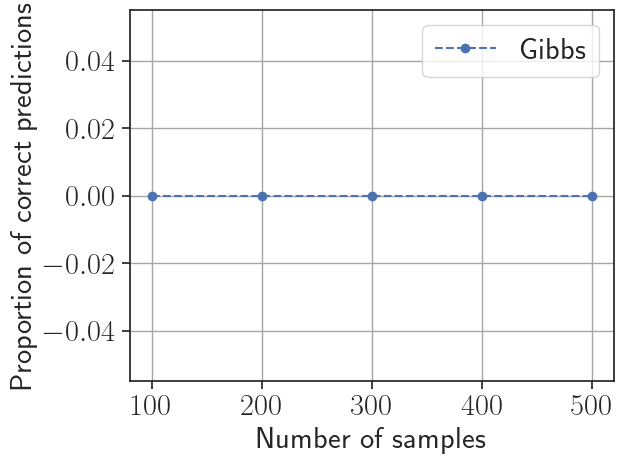

In [ ]:
i = 23
l_labels = [100, 200, 300, 400, 500]
l_labels_mcmc = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
print(pred_bayes[i])
fig, ax = plt.subplots()
ax.plot(np.array(l_labels), all_probs_gibbs[i, :], label = "Gibbs", marker = "o", ls = "--")
#ax.plot(np.array(l_labels_mcmc), l_mcmc[i, :], label = "MCMC", marker = "o", ls = "--")
plt.xlabel("Number of samples")
plt.ylabel("Proportion of correct predictions")
plt.grid(True, which="both", ls="-", color='0.65')
ax.legend()
plt.tight_layout()
plt.show()

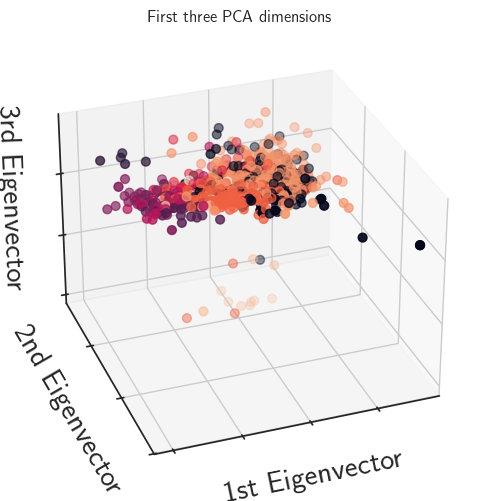

In [ ]:
import matplotlib.pyplot as plt

# unused but required import for doing 3d projections with matplotlib < 3.2
 # noqa: F401

from sklearn.decomposition import PCA

fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

X_reduced = PCA(n_components=3).fit_transform(X)
scatter = ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    X_reduced[:, 2],
    c = np.array([cats[c] for c in y]),
    s=40,
)

ax.set(
    title="First three PCA dimensions",
    xlabel="1st Eigenvector",
    ylabel="2nd Eigenvector",
    zlabel="3rd Eigenvector",
)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

plt.show()

# Compute all posterior probabilities and check how many runs of MCMC / Gibbs fall in the confidence interval

In [163]:
dic_chain_mcmc = pickle.load(open("drive/MyDrive/results_gretsi/mcmc_chains.p", "rb"))
dic_chain_bayes = pickle.load(open("drive/MyDrive/results_gretsi/mcmc_bayes_m.p", "rb"))
mcmc_chains = dic_chain_mcmc["chains_mh"]
mcmc_bayes = dic_chain_bayes["chain_bayes"]

In [152]:
#rebuild gibbs with 500 particles and 100 chains
dic_chain_gibbs_100 = pickle.load(open("drive/MyDrive/results_gretsi/mala_chains/chain_gibbs_100.p", "rb"))
all_chains = dic_chain_gibbs_100["chains"]
all_acceptance = dic_chain_gibbs_100["acceptance"]
n_chains = 50
N = 100
d = 81
beta_N = 2*N**2
n_iter = 50_000
step_size = 0.1
target_mala = gibbs(d = d, N = N, K = K, V = V, beta_N = beta_N)
mvn_d = numpyro.distributions.MultivariateNormal(loc=jnp.zeros(d), covariance_matrix= jnp.eye(d))
mala_jitted = jit(vmap(partial(mala,
                               log_prob_target = target_mala.log_prob,
                               n_iter = n_iter,
                               step_size =  step_size * beta_N**(-1))))

In [153]:
dic_chain_gibbs_100["n_iter"] = n_iter
dic_chain_gibbs_100["step_size"] = step_size
for i in range(n_chains):
    print(i)
    key, _ = random.split(key, 2)
    start_sample = mvn_d.sample(key, (N, )).reshape((1, d*N))
    sample_mala, acceptance = mala_jitted(random.split(key, 1), start_sample)
    sample_mala_reshaped = sample_mala.reshape(d, N).T
    all_acceptance = all_acceptance.at[i].set(acceptance[0])
    all_chains = all_chains.at[i, :, :].set(sample_mala_reshaped)
    dic_chain_gibbs_100["acceptance"] = all_acceptance
    dic_chain_gibbs_100["chains"] = all_chains
    pickle.dump(dic_chain_gibbs_100, open("drive/MyDrive/results_gretsi/mala_chains/chain_gibbs_100.p", "wb"))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [173]:
i = 10
n_chains = 50
gibbs_chain_100 = all_chains
log_post_bayes = np.array([log_posterior(mcmc_bayes[0, :, :], x = X_test[i, :], cat = cat) for cat in cats.keys()])
log_post_bayes = log_post_bayes - scipy.special.logsumexp(log_post_bayes)
log_post_gibbs = np.zeros(shape = (n_chains, 10))
log_post_mcmc = np.zeros(shape = (n_chains, 10))
for j in range(n_chains):
    log_post_gibbs_j = np.array([log_posterior(gibbs_chain_100[j, :, :], x = X_test[i, :], cat = cat) for cat in cats.keys()])
    log_post_gibbs[j, :] = log_post_gibbs_j - scipy.special.logsumexp(log_post_gibbs_j)
for j in range(n_chains):
    log_post_mcmc_j = np.array([log_posterior(mcmc_chains[j, 500:600, :], x = X_test[i, :], cat = cat) for cat in cats.keys()])
    log_post_mcmc[j, :] = log_post_mcmc_j - scipy.special.logsumexp(log_post_mcmc_j)


In [174]:
def props_in_ci(log_posts, delta):
    n_chains, n_cats = log_posts.shape
    prop_ci = 0.
    l_prob_ci_up = np.zeros(shape = (n_cats))
    l_prob_ci_down = np.array([-np.inf for i in range(n_cats)])
    for i in range(n_cats):
        if np.exp(log_post_bayes[i]) < 1 - delta:
            l_prob_ci_up[i] = np.log(np.exp(log_post_bayes[i]) + delta)
        if np.exp(log_post_bayes[i]) > delta:
            l_prob_ci_down[i] = np.log(np.exp(log_post_bayes[i]) - delta)

    for j in range(n_chains):
        flag = True
        for i in range(n_cats):
            l_prob = log_posts[j, i]
            if l_prob > l_prob_ci_up[i] or l_prob < l_prob_ci_down[i]:
                flag = False
        if flag:
            prop_ci+=1.
    return prop_ci / n_chains



In [108]:
props_in_ci(log_post_gibbs, delta = 0.033)

0.02

In [111]:
props_in_ci(log_post_mcmc, delta = 0.00)

0.0

#to discuss:
self normalization of log probas for posterior,
n_iter and step size for mala...
burn in for mcmc
nb of chains?
sample initial trop bon?

In [175]:
l_delta = [k*1e-3 for k in range(1, 201)]
l_gibbs = np.array([props_in_ci(log_post_gibbs, delta = delta) for delta in l_delta])
l_mcmc = np.array([props_in_ci(log_post_mcmc, delta = delta) for delta in l_delta])

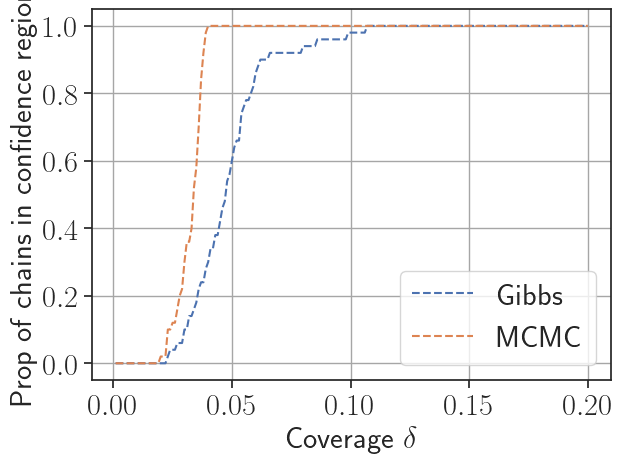

In [176]:
fig, ax = plt.subplots()
ax.plot(np.array(l_delta), l_gibbs, label = "Gibbs", ls = "--")
ax.plot(np.array(l_delta), l_mcmc, label = "MCMC", ls = "--")
plt.xlabel("Coverage $\delta$")
plt.ylabel("Prop of chains in confidence region")
plt.grid(True, which="both", ls="-", color='0.65')
ax.legend()
#ax.set_xscale('log')
plt.tight_layout()
plt.show()

In [151]:
key, _ = random.split(key, 2)
target_mala = gibbs(d = d, N = N, K = K, V = V, beta_N = beta_N)
start_sample = mvn_d.sample(key, (N, )).reshape((1, d*N))
mala_jitted = jit(vmap(partial(mala,
                               log_prob_target = target_mala.log_prob,
                               n_iter = 50_000,
                               step_size =  0.1 * beta_N**(-1))))
sample_mala, acceptance = mala_jitted(random.split(key, 1), start_sample)
sample_mala_reshaped = sample_mala.reshape(d, N).T
print(acceptance)
sample_mala_reshaped[499, :]

[1.]


Array([ 19.31592796, -20.81450324, -10.8045934 ,  22.55145392,
       -15.9480183 ,  -7.82555531, -13.53993014,  46.93350055,
        37.62557832,   2.85799017, -29.18672836, -19.81110339,
        -9.29552951,   5.9180542 ,  35.22156439,  15.58265558,
        -2.19427719,  12.69560372,   3.79628351,  18.28953642,
        15.18036565,  11.87948041,  40.94263405, -51.21049768,
        12.41607492, -16.68094917, -12.5229051 , -35.48388795,
        47.48281333,   8.50325418, -38.8240922 ,   1.50442788,
       -17.28622071, -14.55931001,  33.51718747,   1.00862673,
       -14.49421779,  -2.8789906 ,  10.60188523,  30.18409798,
         2.15366047, -68.31862077, -13.38578202,   9.1757216 ,
        12.62633492,  18.4972138 ,  -2.02841246,  -7.0570232 ,
        46.60705001, -25.55939052, -31.38101958,  -6.42290492,
        -2.04308991,  -5.2861799 ,  17.33078406,   7.49537235,
        -4.19259023,  -3.45453388, -23.98186083, -19.07994835,
         1.71553286,  -4.58860933,  -2.89047816,  27.90